In [1]:
import numpy as np
import pandas as pd
import pickle

#img show and plotting
import matplotlib.pyplot as plt
import seaborn as sns

#image functions
from ImageFunctions import get_color_description, plot_color_hist, show_image, load_image, show_save_imageee
from ImageFunctions import show_images, get_categories_top_bottom_imgs, get_sorted_distances_list, remove_bottom_imgs
from ImageFunctions import get_bottleneck_features

# color distributions
import cv2

# class imbalance
import random

# splitting
from sklearn.model_selection import train_test_split

# vgg model
from keras.models import Model
from keras.applications import vgg16
import keras

# img augmentation
from skimage import exposure, transform
from skimage.util import random_noise

C:\Users\prakruthimadhav\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#data saved to local drive
X = np.load('C:/Users/prakruthimadhav/Documents/code red/travel/X2new.npy')
df = pd.read_pickle('C:/Users/prakruthimadhav/Documents/code red/travel/Y2new.pkl')
df=df.head(999)
print(X.shape, df.shape) #check for same length

(999, 150, 150, 3) (999, 4)


In [3]:
df['category'].value_counts()

beaches/ocean    348
landmarks        187
museums          174
entertainment    116
gardens/zoo      116
parks             58
Name: category, dtype: int64

In [4]:
df.reset_index(inplace=True)
df.drop(['index'], 1, inplace=True)
df.tail(2)

C:\Users\prakruthimadhav\AppData\Local\Temp\ipykernel_20440\3473096463.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['index'], 1, inplace=True)


name                                       location   category  \
997  Fort Gaines  51 Bienville Avenue, Dauphin Island, AL 36528  landmarks   
998  Fort Gaines  51 Bienville Avenue, Dauphin Island, AL 36528  landmarks   

                                                   url  
997  https://media-cdn.tripadvisor.com/media/photo-...  
998  https://media-cdn.tripadvisor.com/media/photo-...

In [5]:
print(X.shape, df.shape) #check for same length

(999, 150, 150, 3) (999, 4)


In [6]:
bins = [8,8,8]
#BGR2HSV
#BGR2RGB

#get color feats and add to df
color_feats = []
for x in X:
    color_feats.append(get_color_description(x, bins))

np.array(color_feats).shape

(999, 4096)

In [7]:
df['color_feats'] = color_feats
df.info()

del color_feats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         999 non-null    object
 1   location     999 non-null    object
 2   category     999 non-null    object
 3   url          999 non-null    object
 4   color_feats  999 non-null    object
dtypes: object(5)
memory usage: 39.1+ KB


In [8]:
# create vgg model
inputs = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=inputs)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

#dont want model weights to change durring training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# get vgg features for all imgs and add to df
feats_arr = get_bottleneck_features(vgg_model, X)

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         999 non-null    object
 1   location     999 non-null    object
 2   category     999 non-null    object
 3   url          999 non-null    object
 4   color_feats  999 non-null    object
dtypes: object(5)
memory usage: 39.1+ KB


In [9]:
feats_lists = []
for x in feats_arr:
    feats_lists.append(x)

len(feats_lists)

999

In [10]:
df['vgg_feats'] = feats_lists

del feats_arr, feats_lists

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         999 non-null    object
 1   location     999 non-null    object
 2   category     999 non-null    object
 3   url          999 non-null    object
 4   color_feats  999 non-null    object
 5   vgg_feats    999 non-null    object
dtypes: object(6)
memory usage: 47.0+ KB


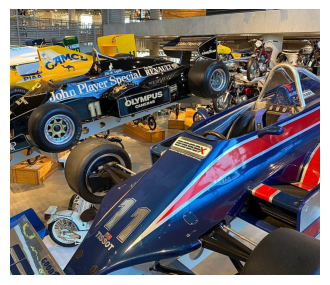

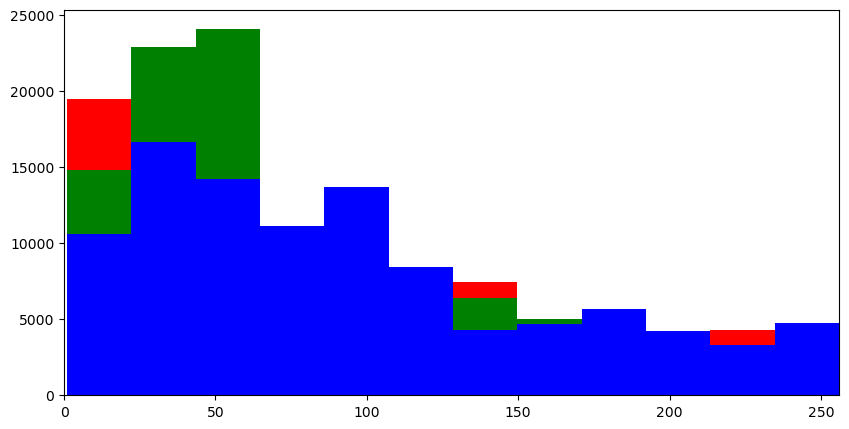

In [14]:
idx = 1
url = df.loc[idx, 'url']

# load, show and save img
img = load_image(url)
show_save_imageee(img, 'color_feats')

# grab the dimensions and compute the center of the image
(h, w) = img.shape[:2]
(cX, cY) = (int(w * 0.5), int(h * 0.5))

# divide the image into four rectangles/segments (top-left, top-right, bottom-right, bottom-left)
segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]

rect = []
# loop over the segments
for (startX, endX, startY, endY) in segments:
    # construct a mask for each corner of the image, subtracting the elliptical center from it
    cornerMask = np.zeros(img.shape[:2], dtype = "uint8")
    rect.append((cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 1, -1))) #*img))

# get color distributions for top-right of image
bins = 12
mask = rect[2]
plot_color_hist(img, bins, mask, None)

In [21]:
df.head()

name  \
0  Barber Vintage Motorsports Museum   
1  Barber Vintage Motorsports Museum   
2  Barber Vintage Motorsports Museum   
3  Barber Vintage Motorsports Museum   
4  Barber Vintage Motorsports Museum   

                                            location category  \
0  6030 Barber Motorsports, Birmingham, AL 35094-...  museums   
1  6030 Barber Motorsports, Birmingham, AL 35094-...  museums   
2  6030 Barber Motorsports, Birmingham, AL 35094-...  museums   
3  6030 Barber Motorsports, Birmingham, AL 35094-...  museums   
4  6030 Barber Motorsports, Birmingham, AL 35094-...  museums   

                                                 url  \
0  https://dynamic-media-cdn.tripadvisor.com/medi...   
1  https://dynamic-media-cdn.tripadvisor.com/medi...   
2  https://dynamic-media-cdn.tripadvisor.com/medi...   
3  https://media-cdn.tripadvisor.com/media/photo-...   
4  https://media-cdn.tripadvisor.com/media/photo-...   

                                         color_feats  \
0  [0.004312446, 0.0, 0.0, 0.04420257, 0.09810814...   
1  [0.006336804, 0.002112268, 0.0, 0.035908557, 0...   
2  [0.009769978, 0.0, 0.0, 0.013026638, 0.0358232...   
3  [0.0018022985, 0.0, 0.0, 0.00090114924, 0.0072...   
4  [0.0072319685, 0.026035085, 0.018803118, 0.046...   

                                           vgg_feats  
0  [11.510083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 71.7...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 13.16085, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 1.0281299, 0.0, 0.0, 0.0,...

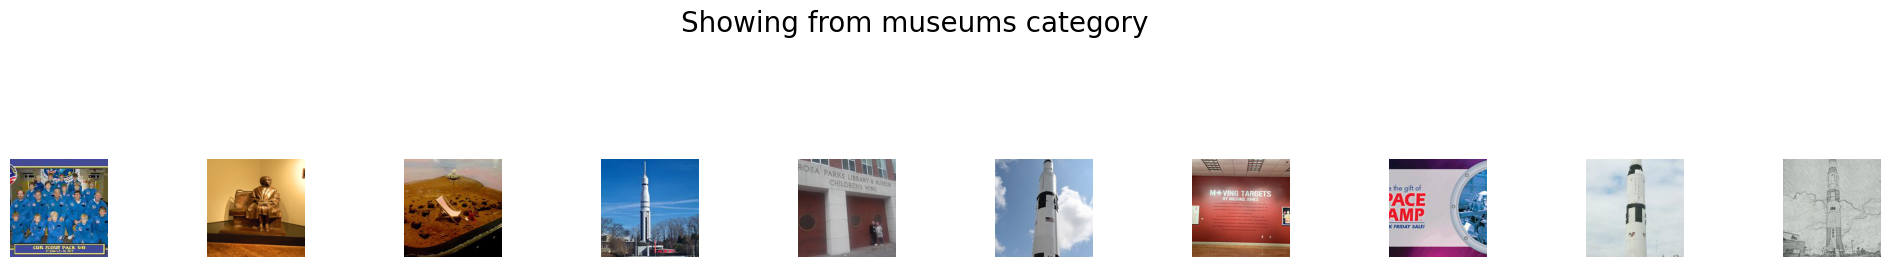

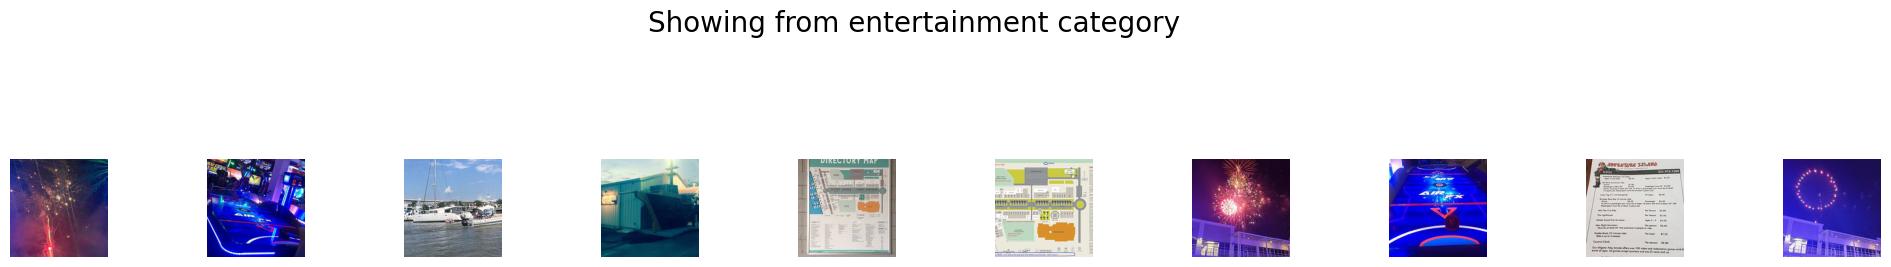

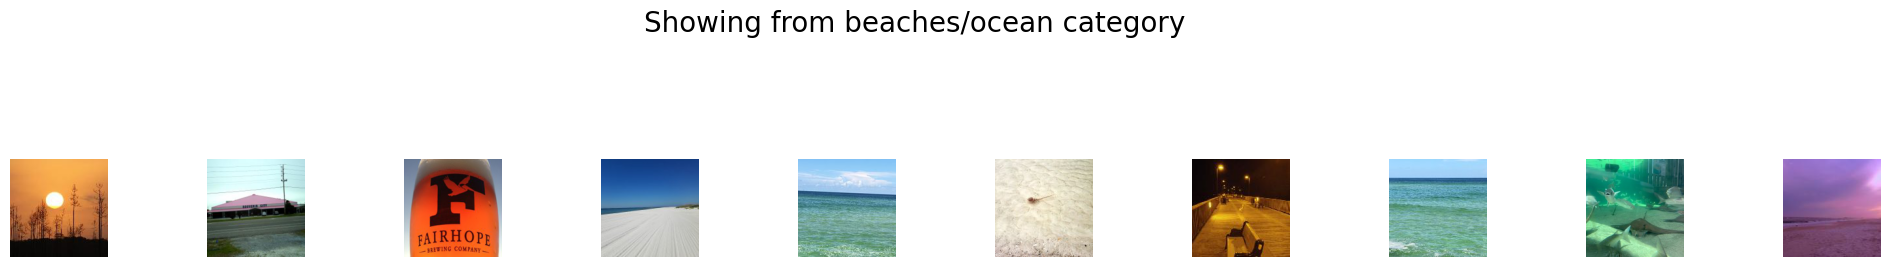

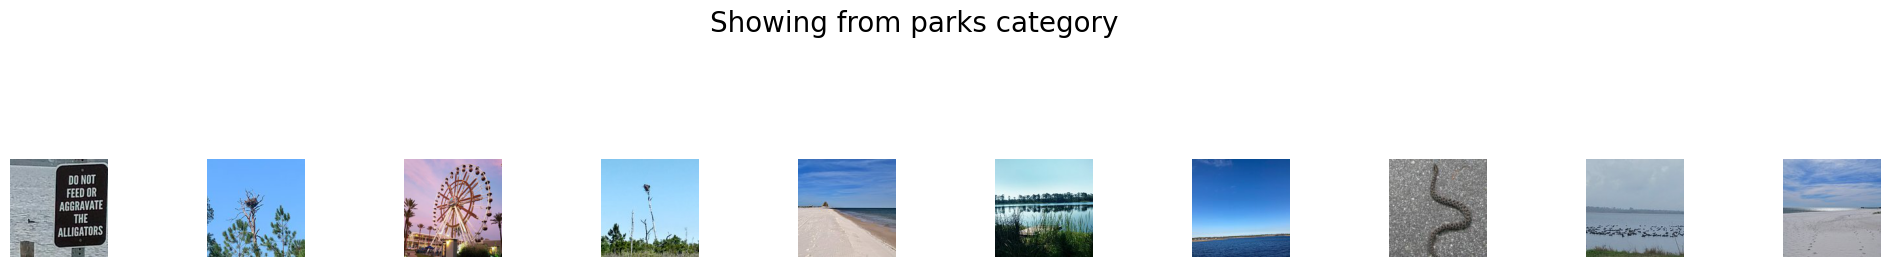

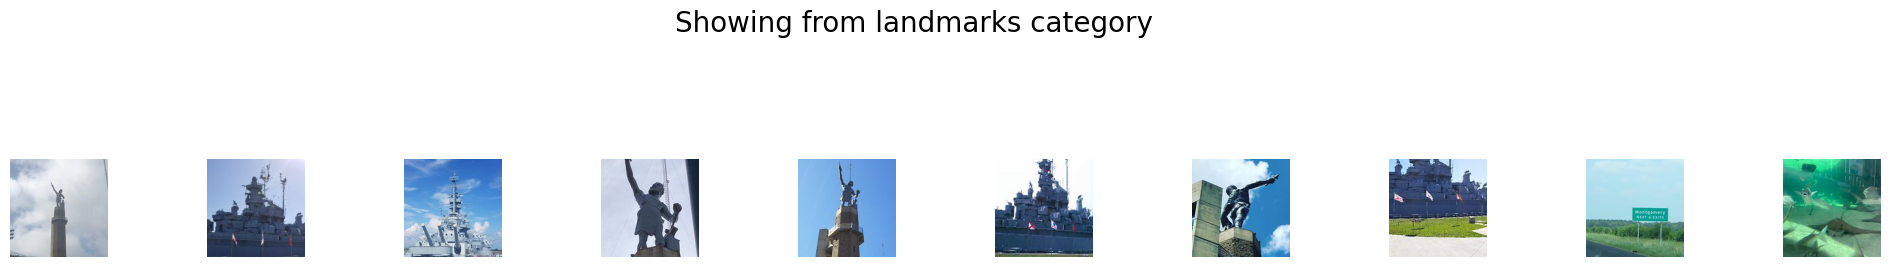

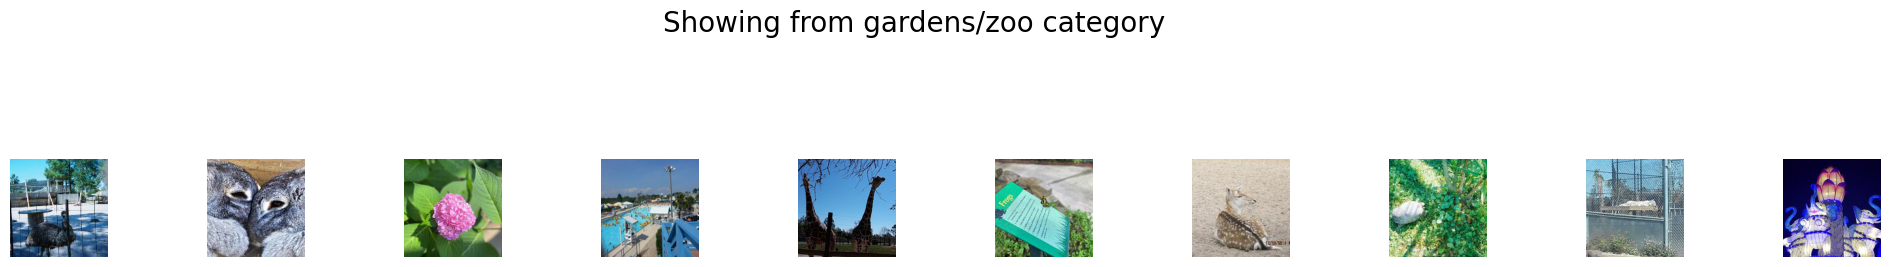

In [21]:
#categories = ['museums', 'parks','beaches/ocean', 'gardens/zoo', 'landmarks',  'art', 'entertainment', 'sports']
categories = ['museums' ,'entertainment' ,'beaches/ocean' ,'parks', 'landmarks','gardens/zoo']

firstimgs, lastimgs = get_categories_top_bottom_imgs(df, categories, 10)

for key,value in lastimgs.items():
    show_images(X[value], key)

In [18]:
unique_categories = df['category'].unique()
print(unique_categories)


['museums' 'entertainment' 'beaches/ocean' 'parks' 'landmarks'
 'gardens/zoo']


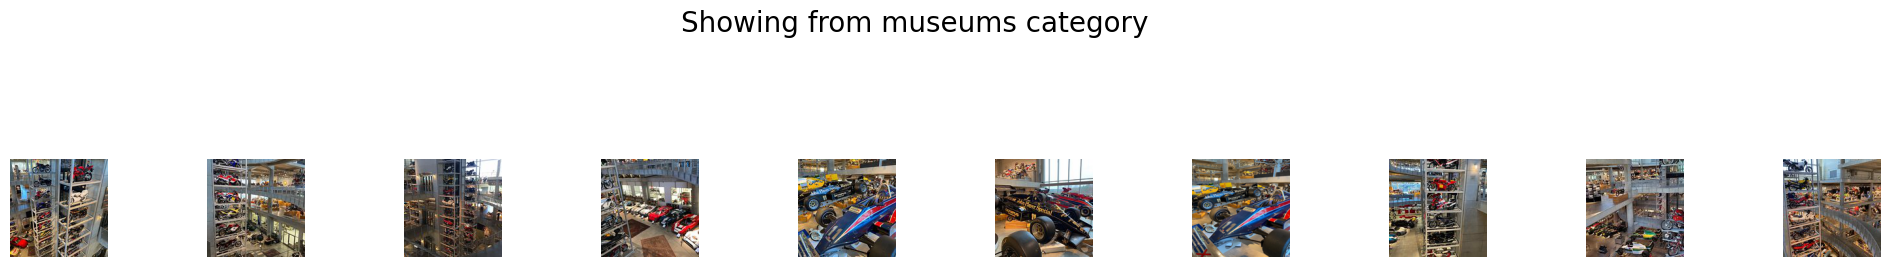

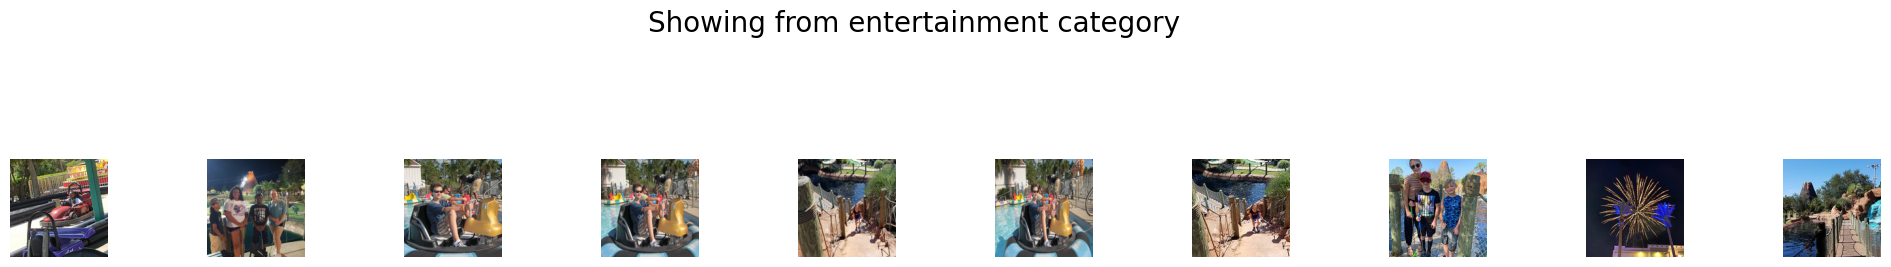

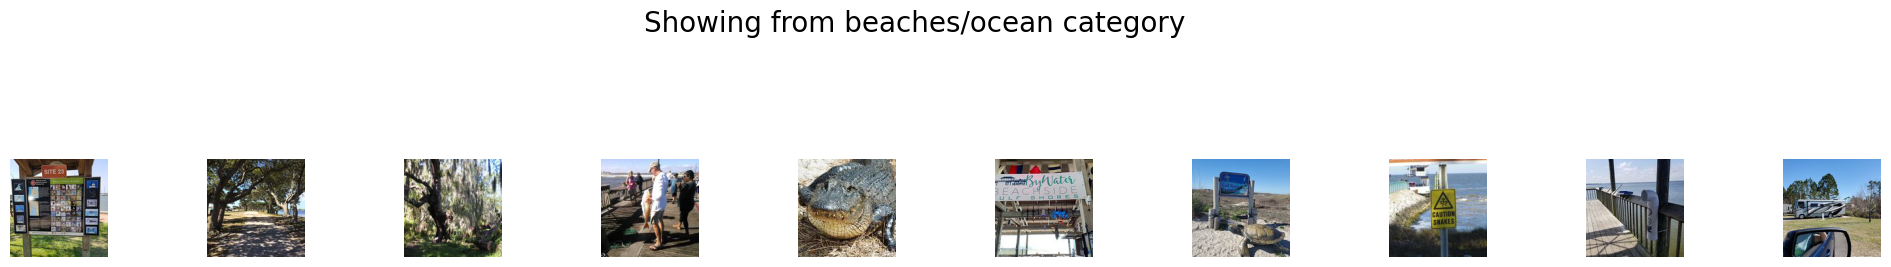

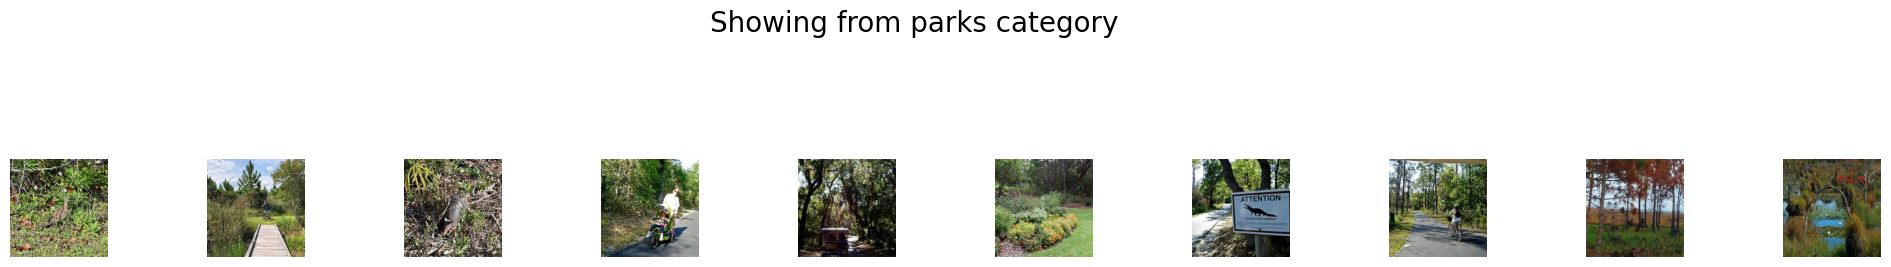

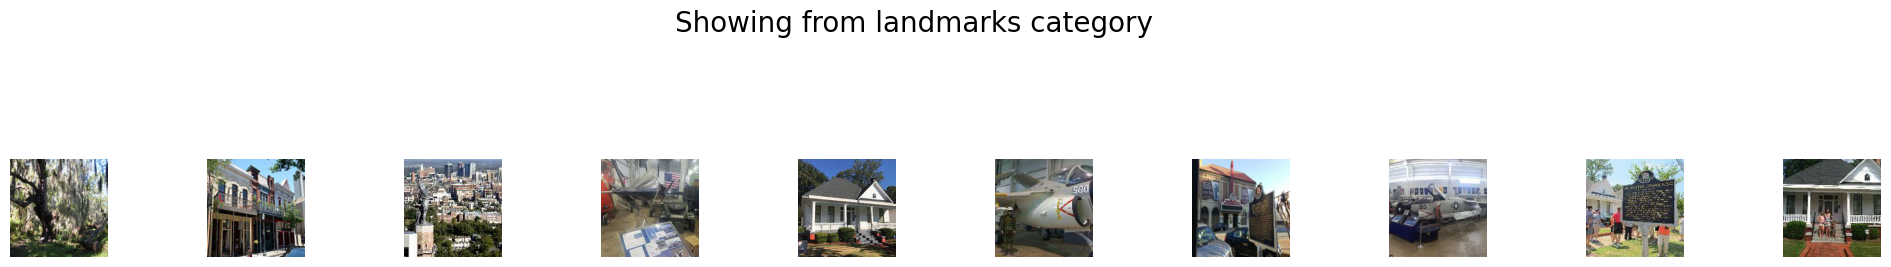

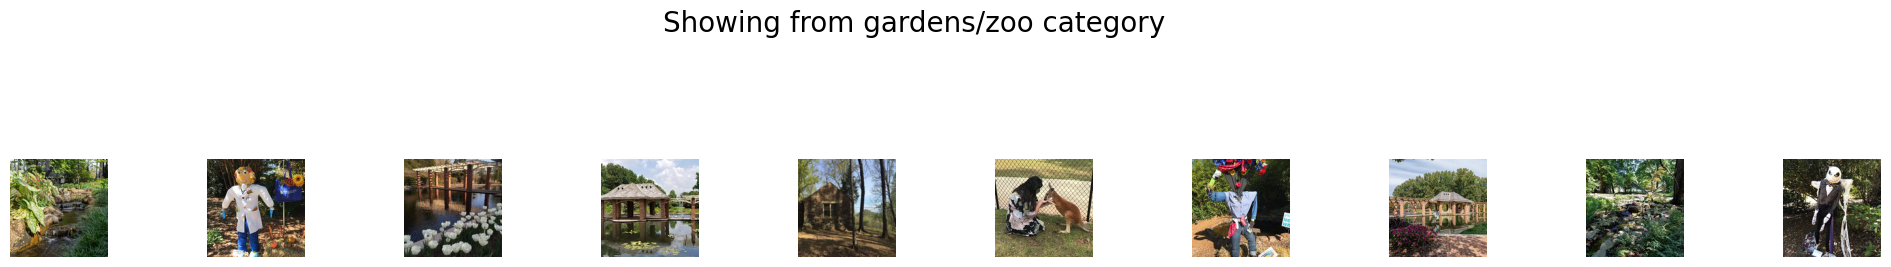

In [22]:
for key,value in firstimgs.items():
    show_images(X[value], key)

In [23]:
# remove furthest imgs
remove = []
X_cleaned, df_cleaned = remove_bottom_imgs(X, df, categories, lastimgs, remove)
print(X_cleaned.shape, df_cleaned.shape)

# clear up memory
# del X
# del df

(939, 150, 150, 3) (939, 6)


C:\Users\prakruthimadhav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


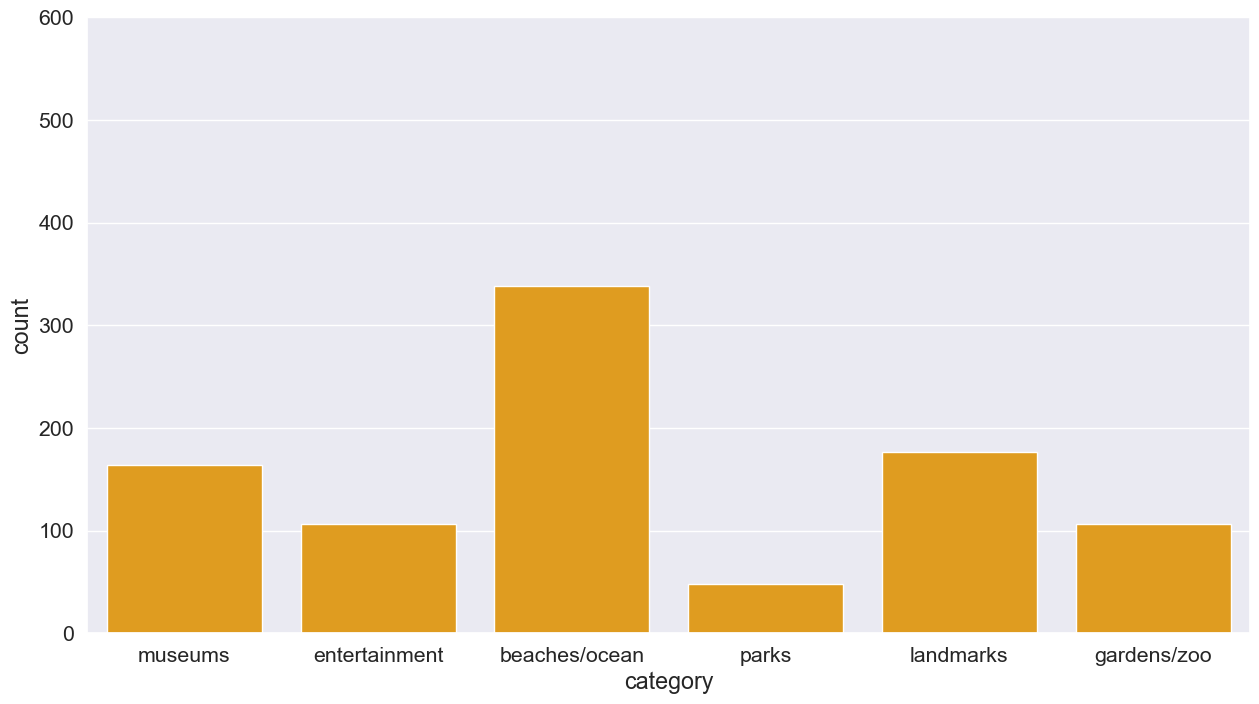

In [28]:
# investigate class imbalance
plt.rcParams['figure.figsize']=(15,8)
sns.set(font_scale = 1.4)
sns.countplot(df_cleaned['category'], palette=['orange'])
plt.ylim((0,600))

plt.savefig('C:/Users/prakruthimadhav/Documents/code red/travel/Graphs/imbalanced.png')


museums 82
museums 82
entertainment 77
entertainment 77
beaches/ocean 169
beaches/ocean 169
landmarks 88
landmarks 89
gardens/zoo 53
gardens/zoo 53


C:\Users\prakruthimadhav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


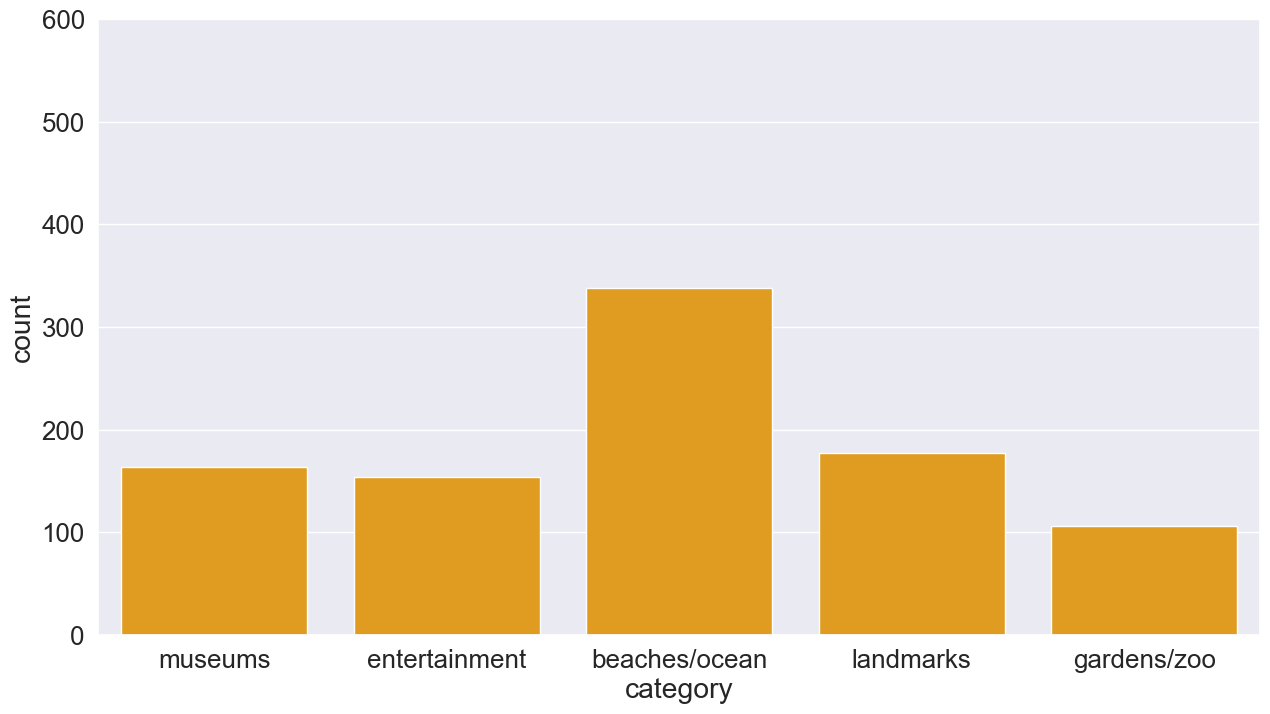

In [31]:
df_cleaned_classes = df_cleaned.copy()
df_cleaned_classes = df_cleaned_classes.reset_index()
X_cleaned_classes = X_cleaned.copy()

# replace sports and art classes
df_cleaned_classes['category'] = df_cleaned_classes['category'].str.replace('parks','entertainment')
#rachel's---['museums', 'parks','beaches/ocean', 'gardens/zoo', 'landmarks',  'art', 'entertainment', 'sports']
#mine---['museums' 'entertainment' 'beaches/ocean' 'parks' 'landmarks''gardens/zoo']
# save each category as pickle
new_cats =['museums' ,'entertainment' ,'beaches/ocean' , 'landmarks','gardens/zoo']
new_cats_name = ['museums' ,'entertainment_parks' ,'beaches_ocean' , 'landmarks','gardens_zoo']
grouped = df_cleaned_classes.groupby('category')
for idx, cat in enumerate(new_cats):
    group = pd.DataFrame(grouped.get_group(cat)).reset_index()
    group.drop(['category', 'level_0', 'index'], axis = 1, inplace=True)
    mid = len(group) // 2
    letter = ['A', 'B']
    for x in letter:
        local_path ='C:/Users/prakruthimadhav/Documents/code red/travel/Data/' + new_cats_name[idx] + '_' + x + '_df.pkl'
        if x == 'A':
            half_df = group[:mid]
        else:
            half_df = group[mid:]
        print(cat, len(half_df))
#         half_df.to_pickle(local_path)

#clear up memory
# del df_cleaned
# del X_cleaned

# check for class removal
sns.set(font_scale = 1.7)
sns.countplot(df_cleaned_classes['category'], palette=['orange'])
plt.ylim((0,600))

plt.savefig('C:/Users/prakruthimadhav/Documents/code red/travel/Graphs/class_removal.png')

In [33]:
# find difference between museum and parks classes to find number of images to remove
museum_len = len(grouped.get_group('museums'))
parks_len = len(grouped.get_group('beaches/ocean'))
num_to_remove = parks_len - museum_len

# get list of parks indexes and randomly sample
parks_indexes = grouped.get_group('beaches/ocean').index.tolist()
indexes_to_remove =  random.sample(parks_indexes, num_to_remove)
print(num_to_remove, len(indexes_to_remove))

# drop indexes from df and X images
df_cleaned_classes.drop(df_cleaned_classes.index[indexes_to_remove], inplace = True)
X_cleaned_classes = np.delete(X_cleaned_classes, indexes_to_remove, 0)
print(len(df_cleaned_classes), len(X_cleaned_classes))

174 174
765 765


C:\Users\prakruthimadhav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


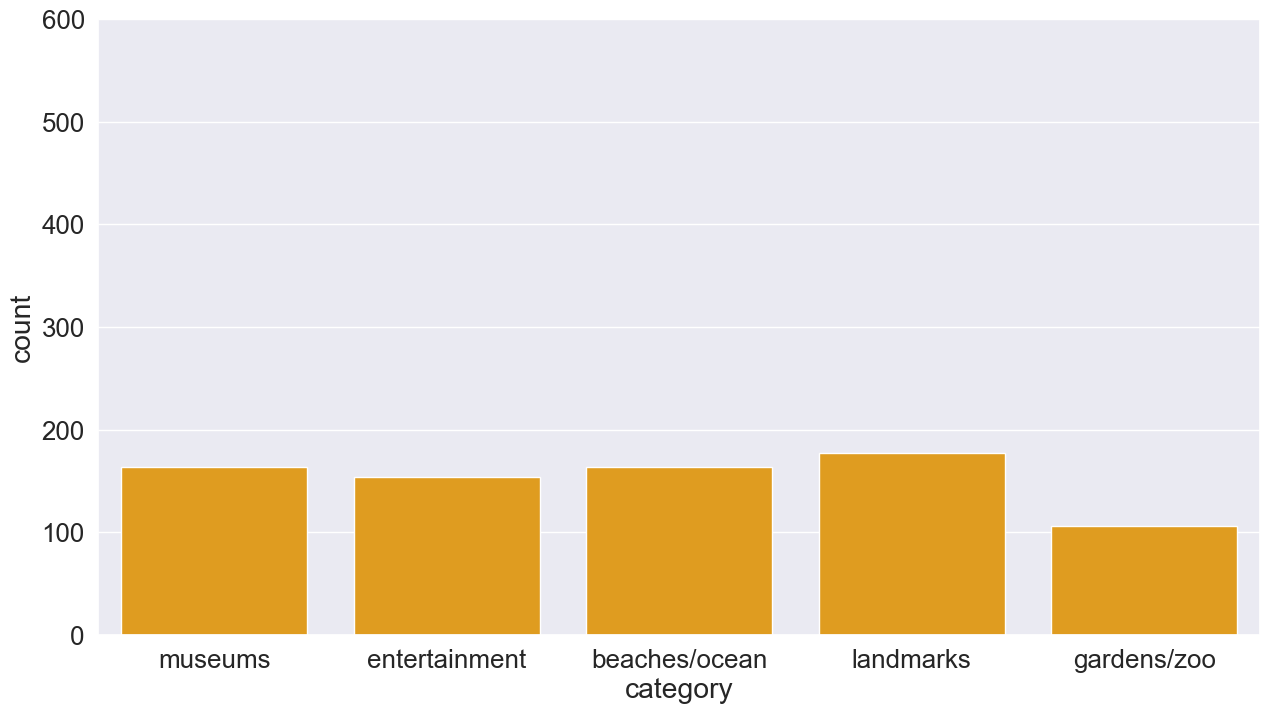

In [35]:
# check for class balance
sns.countplot(df_cleaned_classes['category'], palette=['orange'])
plt.ylim((0,600))

plt.savefig('C:/Users/prakruthimadhav/Documents/code red/travel/Graphs/undersampling.png')

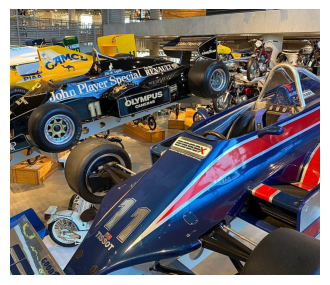

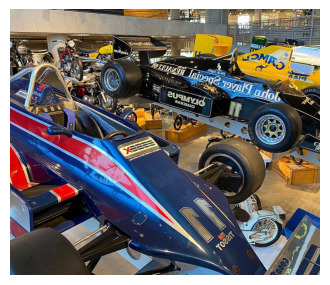

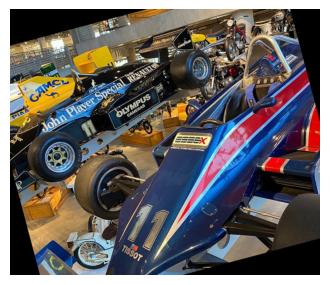

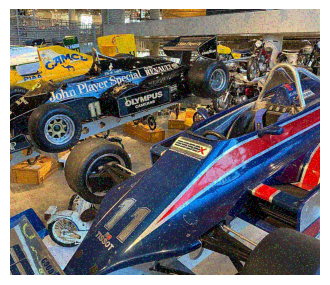

In [39]:
# load and save img
url = df_cleaned_classes.loc[1, 'url']
img = load_image(url)
show_save_imageee(img, 'regular')

# augment img and save
horiz = np.fliplr(img)
show_save_imageee(horiz, 'flipped')
trans = transform.rotate(img, random.uniform(-30,30))
show_save_imageee(trans, 'transformed')
noise = random_noise(img, mode='s&p', clip=True)
show_save_imageee(noise, 'noise')

In [42]:
y = df_cleaned_classes['category']

# create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_classes, y, test_size=0.2)

# create training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(459, 150, 150, 3) (153, 150, 150, 3) (153, 150, 150, 3)
(459,) (153,) (153,)


In [ ]:
# save cleaned X
np.savez_compressed('C:/Users/prakruthimadhav/Documents/code red/travel/X_train_clean.npz',X_train)
# del X_train
np.savez_compressed('C:/Users/prakruthimadhav/Documents/code red/travel/X_test_clean.npz',X_test)
# del X_test
np.savez_compressed('C:/Users/prakruthimadhav/Documents/code red/travel/X_val_clean.npz',X_val)
# del X_val

# save cleaned Y locally
# y_train.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_train_clean.pkl')
# y_test.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_test_clean.pkl')
# y_val.to_pickle('/Users/racheldilley/Documents/lets-take-a-trip-data/Y_val_clean.pkl')

# svaing locally for google cloud platform
y_train.to_pickle('C:/Users/prakruthimadhav/Documents/code red/travel/Y_train_clean.pkl', protocol=2)
y_test.to_pickle('C:/Users/prakruthimadhav/Documents/code red/travel/Y_test_clean.pkl', protocol=2)
y_val.to_pickle( 'C:/Users/prakruthimadhav/Documents/code red/travel/Y_val_clean.pkl', protocol=2)